In [310]:
from __future__ import division
import pandas as pd
import numpy as np
import gzip
import cPickle as pickle
import json

import scipy.stats

from time import strftime

import sys

from collections import Counter
from operator import itemgetter

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../TrainModels')
sys.path.append('../../ApplyModels')
sys.path.append('../../Utils')
from utils import filter_by_filelist, plot_labelled_bb
from utils import saiapr_image_filename, mscoco_image_filename, separation_plot
from train_model import STOPWORDS, is_relational
from train_model import create_word2den, make_train
from apply_model import make_test
#from augment_model import compute_confidences

In [300]:
def run_wac_on_data(refdf, X, wac, word, nneg=3, nsrc='random'):
    w2d = create_word2den(refdf, [word])
    X_t, y_t = make_train(X, w2d, word, nneg, nsrc)
    res = wac[word]['clsf'].predict_proba(X_t)[:,1]
    return res, np.array(y_t)

def score_wac_on_data(refdf, X, wac, word, nneg=3, nsrc='random'):
    w2d = create_word2den(refdf, [word])
    if word not in w2d:
        return np.nan
    X_t, y_t = make_train(X, w2d, word, nneg, nsrc)
    res = wac[word]['clsf'].score(X_t, y_t)
    return res

def acc_vs_ntrain(testdf, X, wac, vocab):
    scores = []
    posinst = []
    for word in tqdm(vocab):
        scores.append(score_wac_on_data(testdf, X, wac, word))
        posinst.append(wac[word]['npos'])
    return posinst, scores

In [14]:
pd.set_option('display.max_colwidth', 100)

### Load up data

In [2]:
with gzip.open('../../Preproc/PreProcOut/saiapr_refdf.pklz', 'r') as f:
    srefdf = pickle.load(f)

with gzip.open('../../Preproc/PreProcOut/refcoco_refdf.pklz', 'r') as f:
    rrefdf = pickle.load(f)

with gzip.open('../../Preproc/PreProcOut/grex_refdf.pklz', 'r') as f:
    grefdf = pickle.load(f)



## Splits

with open('../../Preproc/PreProcOut/saiapr_90-10_splits.json', 'r') as f:
    ssplit90 = json.load(f)

with open('../../Preproc/PreProcOut/refcoco_splits.json', 'r') as f:
    rcocosplits = json.load(f)

# rcocosplits.keys(), map(len, rcocosplits.values())
# ([u'testA', u'train', u'val', u'testB'], [750, 16994, 1500, 750])



## Bounding box definitions

with gzip.open('../../Preproc/PreProcOut/berkeley_bbdf.pklz', 'r') as f:
    b_bbdf = pickle.load(f)
with gzip.open('../../Preproc/PreProcOut/saiapr_bbdf.pklz', 'r') as f:
    s_bbdf = pickle.load(f)
with gzip.open('../../Preproc/PreProcOut/cocogrprops_bbdf.pklz', 'r') as f:
    g_bbdf = pickle.load(f)
with gzip.open('../../Preproc/PreProcOut/mscoco_bbdf.pklz', 'r') as f:
    c_bbdf = pickle.load(f)

In [307]:
X = np.load('/Volumes/USB_128GB/Models/2016-v3-image-wac/saiapr.npz')
X = X['arr_0']

# Analysis of refexp corpora

### Sizes of corpora

In [113]:
map(len, [srefdf, rrefdf, grefdf])

[120081, 142210, 95010]

In [127]:
map(len, map(set, map(lambda x: x.get('image_id').tolist(), [srefdf, rrefdf, grefdf])))

[19989, 19994, 25799]

## Avg number token

In [3]:
def n_token(refexp):
    return len(refexp.split())

In [4]:
np.mean(srefdf['refexp'].apply(n_token))

3.430342851908295

In [5]:
np.mean(rrefdf['refexp'].apply(n_token))

3.5000210955629

In [6]:
np.mean(grefdf['refexp'].apply(n_token))

8.311209346384592

## Some interesting differences btw refcoco & grexp

In [7]:
rrefdf.head(1)

i_corpus  image_id  region_id r_corpus  rex_id  \
0         1    581857    1719310  refcoco       0   

                         refexp  \
0  the lady with the blue shirt   

                                              tagged  
0  [(the, DT), (lady, NN), (with, IN), (the, DT),...

In [8]:
grefdf.head(1)

i_corpus  image_id  region_id r_corpus  rex_id  \
0         1    465670     100000     grex   87967   

                                          refexp  \
0  a brown colored couch with a man laying on it   

                                              tagged  
0  [(a, DT), (brown, NN), (colored, VBD), (couch,...

In [10]:
rrefdf_val = filter_by_filelist(rrefdf, rcocosplits['val'])
grefdf_val = filter_by_filelist(grefdf, rcocosplits['val'])

In [11]:
rg_merged = rrefdf_val.merge(grefdf_val, on=['i_corpus', 'image_id', 'region_id'])

In [22]:
# found by eyballing whole (truncated) rg_merged
exsdf = rg_merged.ix[[22, 28, 11189], ['image_id', 'region_id', 'refexp_x', 'refexp_y']]
exsdf

image_id  region_id     refexp_x  \
22       580905     469475  green woman   
28       580785    1746473          mom   
11189      1488     513940  person left   

                                                     refexp_y  
22                                 a woman wearing blue jeans  
28                         the woman combing the child's hair  
11189  a boy is ready to play who is wearing green color pant

In [25]:
wbb = exsdf.merge(c_bbdf, on=['image_id', 'region_id'])
wbb

image_id  region_id     refexp_x  \
0    580905     469475  green woman   
1    580785    1746473          mom   
2      1488     513940  person left   

                                                 refexp_y  i_corpus  \
0                              a woman wearing blue jeans         1   
1                      the woman combing the child's hair         1   
2  a boy is ready to play who is wearing green color pant         1   

                                 bb  cat  
0  [289.68, 110.25, 290.76, 365.35]    1  
1   [151.7, 173.83, 218.08, 434.57]    1  
2       [0.0, 33.49, 60.72, 281.46]    1

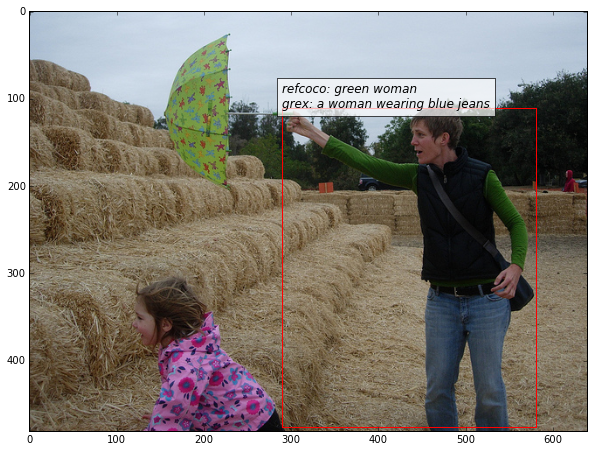

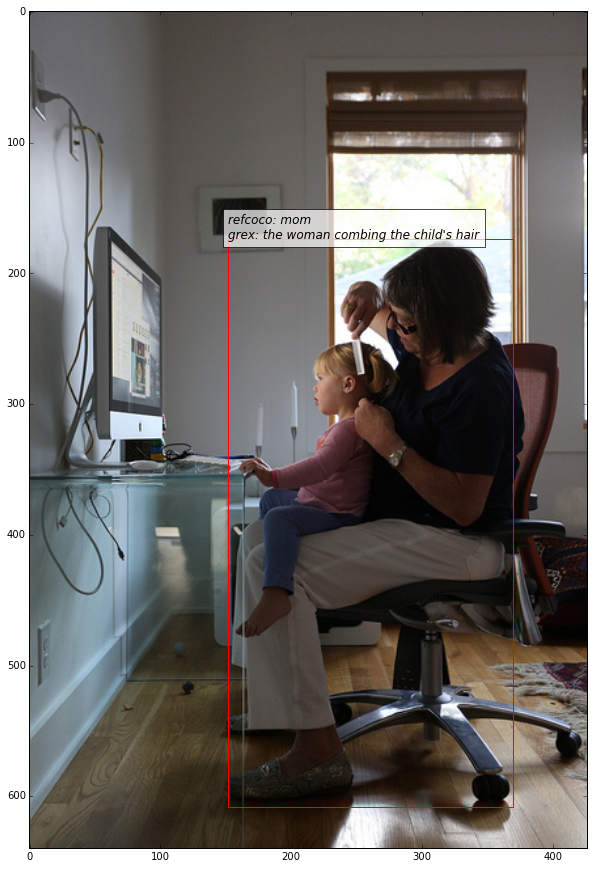

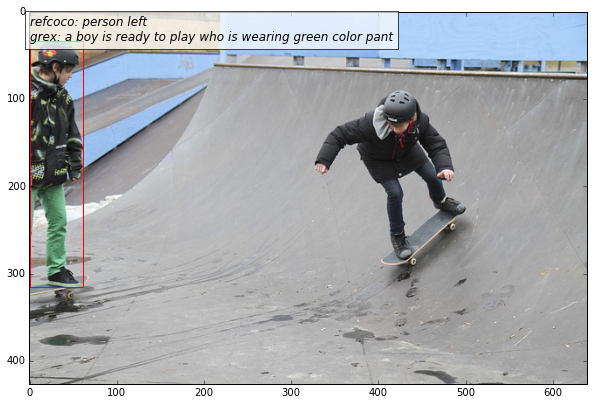

In [32]:
for n, row in wbb.iterrows():
    image_id = row['image_id']
    bb = row['bb']
    rcoco_refexp = row['refexp_x']
    grexp_refexp = row['refexp_y']
    combined = 'refcoco: %s\ngrex: %s' % (rcoco_refexp, grexp_refexp)
    plot_labelled_bb('../' + mscoco_image_filename(image_id), [[bb, combined]])
    plt.savefig('Figures/coco_example_%d.png' % (n), bbox_inches='tight')

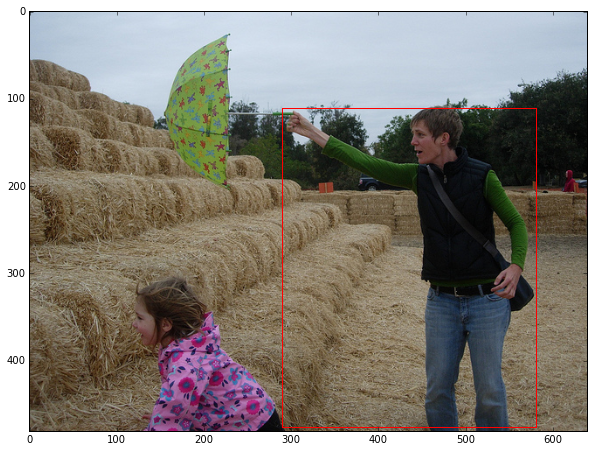

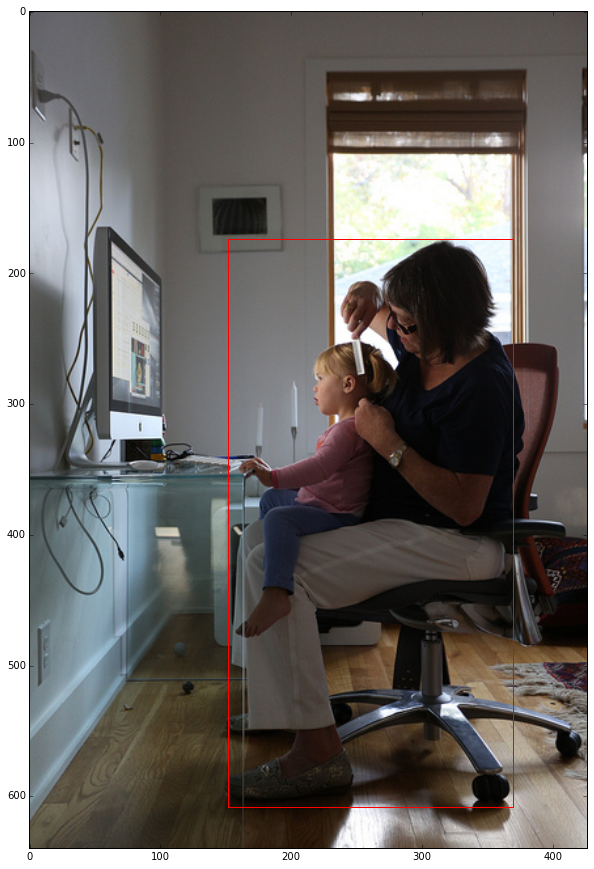

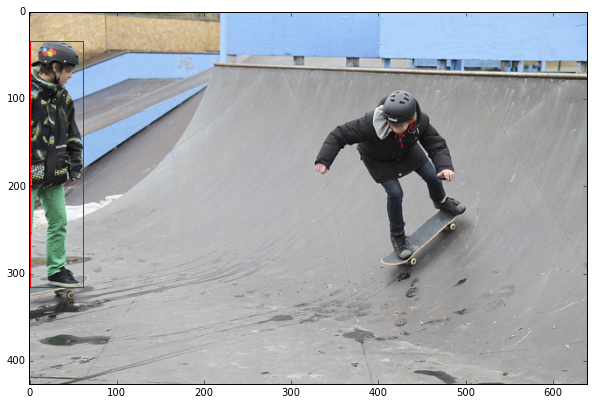

In [272]:
for n, row in wbb.iterrows():
    image_id = row['image_id']
    bb = row['bb']
    rcoco_refexp = row['refexp_x']
    grexp_refexp = row['refexp_y']
    combined = ''
    plot_labelled_bb('../' + mscoco_image_filename(image_id), [[bb, combined]])
    plt.savefig('Figures/coco_example_nolab_%d.png' % (n), bbox_inches='tight')

In [36]:
len(g_bbdf) / len(set(g_bbdf['image_id']))

7.959240389069014

### Some frequency analyses

In [43]:
a = Counter(' '.join(srefdf[:10]['refexp']).split())

In [44]:
a.most_common()

[('the', 5),
 ('sand', 2),
 ('right', 1),
 ('seal', 1),
 ('at', 1),
 ('in', 1),
 ('corner', 1),
 ('wire', 1),
 ('bottom', 1),
 ('top', 1),
 ('sky', 1),
 ('to', 1),
 ('above', 1),
 ('field', 1),
 ('umbrella', 1),
 ('dirt', 1),
 ('very', 1),
 ('but', 1),
 ('water', 1),
 ('path', 1),
 ('tower', 1),
 ('of', 1),
 ('sunray', 1),
 ('chick', 1),
 ('left', 1)]

In [55]:
def freq_analysis(refdf):
    all_token = ' '.join(refdf['refexp']).split()
    counter = Counter(all_token)
    hapax = [w for w,c in counter.items() if c ==1]
    topten = counter.most_common(10)
    return len(all_token), len(counter.keys()), topten, len(hapax)

In [56]:
freq_analysis(srefdf)

(411919,
 10058,
 [('the', 28759),
  ('left', 22911),
  ('right', 22125),
  ('on', 17899),
  ('of', 14547),
  ('sky', 12359),
  ('in', 12194),
  ('bottom', 9550),
  ('top', 7564),
  ('middle', 5854)],
 5935)

In [57]:
freq_analysis(rrefdf)

(497738,
 10341,
 [('left', 33106),
  ('right', 32607),
  ('on', 25765),
  ('in', 20466),
  ('the', 18917),
  ('guy', 11384),
  ('man', 10954),
  ('shirt', 8817),
  ('front', 8090),
  ('of', 7989)],
 5785)

In [58]:
freq_analysis(grefdf)

(789648,
 13945,
 [('a', 91781),
  ('the', 61208),
  ('in', 27529),
  ('with', 23506),
  ('on', 21659),
  ('of', 20782),
  ('and', 15609),
  ('man', 15563),
  ('white', 11982),
  ('to', 10119)],
 6951)

### % train corpus reduced by filtering relational expr

In [60]:
rrefdf_train = filter_by_filelist(rrefdf, rcocosplits['train'])
srefdf_train = filter_by_filelist(srefdf, ssplit90['train'])
grefdf_train = filter_by_filelist(grefdf, rcocosplits['train'])

In [64]:
1 - np.sum(srefdf_train['refexp'].apply(is_relational)) / len(srefdf_train)

0.86107281324314577

In [63]:
1 - np.sum(rrefdf_train['refexp'].apply(is_relational)) / len(rrefdf_train)

0.9468347924127869

In [65]:
1 - np.sum(grefdf_train['refexp'].apply(is_relational)) / len(grefdf_train)

0.82631691801872631

## Reduced WACs

In [83]:
TOP = 20

In [67]:
with gzip.open('../../TrainModels/TrainedModels/model01_s5r.pklz', 'r') as f:
    wac_01 = pickle.load(f)

In [85]:
[w for w,_d in sorted(wac_01.items(), key=lambda x:x[1]['npos'])[::-1][:TOP]]

['left',
 'right',
 'on',
 'sky',
 'in',
 'bottom',
 'top',
 'of',
 'middle',
 'water',
 'corner',
 'person',
 'tree',
 'white',
 'building',
 'people',
 'far',
 'blue',
 'guy',
 'ground']

In [87]:
with gzip.open('../../TrainModels/TrainedModels/model03_r5r.pklz', 'r') as f:
    wac_03 = pickle.load(f)

In [89]:
[w for w,_d in sorted(wac_03.items(), key=lambda x:x[1]['npos'])[::-1][:TOP]]

['left',
 'right',
 'on',
 'in',
 'guy',
 'man',
 'shirt',
 'front',
 'white',
 'with',
 'bottom',
 'person',
 'woman',
 'middle',
 'top',
 'girl',
 'blue',
 'far',
 'black',
 'red']

In [141]:
with gzip.open('../../TrainModels/TrainedModels/model04_g5r.pklz', 'r') as f:
    wac_04 = pickle.load(f)

In [142]:
[w for w,_d in sorted(wac_04.items(), key=lambda x:x[1]['npos'])[::-1][:TOP]]

['in',
 'with',
 'on',
 'man',
 'and',
 'of',
 'white',
 'black',
 'shirt',
 'woman',
 'wearing',
 'is',
 'blue',
 'red',
 'right',
 'holding',
 'to',
 'left',
 'sitting',
 'it']

# Results

In [189]:
with gzip.open('../../ApplyModels/EvalOut/full_df_precomp.pklz', 'r') as f:
    full_df, full_df_rp = pickle.load(f)

In [173]:
pd.set_option('display.precision', 2)

In [174]:
full_df.ix[['01_s5r; mult', '03_r5r; mult', '04_g5r; mult'], ['rnd-full']]

rnd-full
01_s5r; mult      0.20
03_r5r; mult      0.16
04_g5r; mult      0.19

In [175]:
full_df.ix[['max area; s', 'max area; c'], ['acc-full']]

acc-full
max area; s      0.19
max area; c      0.27

I had computed the max area accuracy only by image corpus. But this disregards the fact that refcoco and grexp chose slightly differnt subsets of regions. The post-hoc analysis when reduced to the grexp set is done in `summarise_runs.ipynb`.

In [176]:
full_df.ix[['01_s5r; mult', '01_s5r; mult; NR',
            '03_r5r; mult', '03_r5r; mult; NR',
            '04_g5r; mult', '04_g5r; mult; NR'],
           ['%tst', 'acc-full', 'mrr-full', 'arc-full',
            '>0 wrcov', 'acc->0wc', 'mrr->0wc', 'arc->0wc']]

%tst  acc-full  mrr-full  arc-full  >0 wrcov  acc->0wc  \
01_s5r; mult      1.00      0.65      0.79      0.89      0.97      0.67   
01_s5r; mult; NR  0.86      0.68      0.82      0.91      0.97      0.71   
03_r5r; mult      1.00      0.61      0.77      0.91      0.98      0.62   
03_r5r; mult; NR  0.94      0.63      0.78      0.92      0.98      0.64   
04_g5r; mult      1.00      0.43      0.65      0.86      1.00      0.43   
04_g5r; mult; NR  0.82      0.45      0.67      0.88      1.00      0.45   

                  mrr->0wc  arc->0wc  
01_s5r; mult          0.79      0.92  
01_s5r; mult; NR      0.82      0.94  
03_r5r; mult          0.77      0.93  
03_r5r; mult; NR      0.78      0.94  
04_g5r; mult          0.65      0.87  
04_g5r; mult; NR      0.67      0.88

In [177]:
print(full_df.ix[['01_s5r; mult', '01_s5r; mult; NR',
            '03_r5r; mult', '03_r5r; mult; NR',
            '04_g5r; mult', '04_g5r; mult; NR'],
           ['%tst', 'acc-full', 'mrr-full', 'arc-full',
            '>0 wrcov', 'acc->0wc']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  \%tst &  acc-full &  mrr-full &  arc-full &  >0 wrcov &  acc->0wc \\
\midrule
01\_s5r; mult     &  1.00 &      0.65 &      0.79 &      0.89 &      0.97 &      0.67 \\
01\_s5r; mult; NR &  0.86 &      0.68 &      0.82 &      0.91 &      0.97 &      0.71 \\
03\_r5r; mult     &  1.00 &      0.61 &      0.77 &      0.91 &      0.98 &      0.62 \\
03\_r5r; mult; NR &  0.94 &      0.63 &      0.78 &      0.92 &      0.98 &      0.64 \\
04\_g5r; mult     &  1.00 &      0.43 &      0.65 &      0.86 &      1.00 &      0.43 \\
04\_g5r; mult; NR &  0.82 &      0.45 &      0.67 &      0.88 &      1.00 &      0.45 \\
\bottomrule
\end{tabular}



In [178]:
map(len, map(lambda x: x.keys(), [wac_01, wac_03, wac_04]))

[429, 503, 682]

In [166]:
with gzip.open('../../TrainModels/TrainedModels/model05_sr5r.pklz', 'r') as f:
    wac_05 = pickle.load(f)
with gzip.open('../../TrainModels/TrainedModels/model11_rg5r.pklz', 'r') as f:
    wac_11 = pickle.load(f)
with gzip.open('../../TrainModels/TrainedModels/model10_srg5r.pklz', 'r') as f:
    wac_10 = pickle.load(f)

In [167]:
map(len, map(lambda x: x.keys(), [wac_05, wac_11, wac_10]))

[793, 933, 1215]

In [161]:
rows = ['05_sr5r->s; mult',
            '05_sr5r->r; mult',
            '05_sr5r->g; mult',
            '11_rg5r->s; mult',
            '11_rg5r->r; mult',
            '11_rg5r->g; mult',
            '10_srg5r->s; mult',
            '10_srg5r->r; mult',
            '10_srg5r->g; mult']

rows = [e for t in zip(rows, [r+'; NR' for r in rows]) for e in t]

In [179]:
columns = ['%tst', 'acc-full', 'mrr-full', 'arc-full', '>0 wrcov', 'acc->0wc']

In [180]:
full_df.ix[rows, columns]

%tst  acc-full  mrr-full  arc-full  >0 wrcov  acc->0wc
05_sr5r->s; mult       1.00      0.63      0.77      0.91      0.98      0.65
05_sr5r->s; mult; NR   0.86      0.67      0.81      0.93      0.97      0.69
05_sr5r->r; mult       1.00      0.63      0.78      0.92      0.98      0.64
05_sr5r->r; mult; NR   0.94      0.65      0.79      0.93      0.98      0.66
05_sr5r->g; mult       1.00      0.44      0.66      0.84      1.00      0.44
05_sr5r->g; mult; NR   0.82      0.46      0.67      0.85      1.00      0.46
11_rg5r->s; mult       1.00      0.28      0.52      0.72      0.85      0.33
11_rg5r->s; mult; NR   0.86      0.30      0.55      0.72      0.83      0.36
11_rg5r->r; mult       1.00      0.62      0.78      0.93      0.98      0.63
11_rg5r->r; mult; NR   0.94      0.64      0.79      0.94      0.98      0.65
11_rg5r->g; mult       1.00      0.47      0.68      0.88      1.00      0.47
11_rg5r->g; mult; NR   0.82      0.49      0.69      0.90      1.00      0.49
10_srg5r->s; mult      1.00      0.62      0.76      0.92      0.98      0.63
10_srg5r->s; mult; NR  0.86      0.66      0.80      0.94      0.97      0.68
10_srg5r->r; mult      1.00      0.63      0.78      0.94      0.99      0.64
10_srg5r->r; mult; NR  0.94      0.65      0.79      0.95      0.99      0.66
10_srg5r->g; mult      1.00      0.47      0.68      0.90      1.00      0.47
10_srg5r->g; mult; NR  0.82      0.49      0.70      0.91      1.00      0.49

In [181]:
print(full_df.ix[rows, columns].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  \%tst &  acc-full &  mrr-full &  arc-full &  >0 wrcov &  acc->0wc \\
\midrule
05\_sr5r->s; mult      &  1.00 &      0.63 &      0.77 &      0.91 &      0.98 &      0.65 \\
05\_sr5r->s; mult; NR  &  0.86 &      0.67 &      0.81 &      0.93 &      0.97 &      0.69 \\
05\_sr5r->r; mult      &  1.00 &      0.63 &      0.78 &      0.92 &      0.98 &      0.64 \\
05\_sr5r->r; mult; NR  &  0.94 &      0.65 &      0.79 &      0.93 &      0.98 &      0.66 \\
05\_sr5r->g; mult      &  1.00 &      0.44 &      0.66 &      0.84 &      1.00 &      0.44 \\
05\_sr5r->g; mult; NR  &  0.82 &      0.46 &      0.67 &      0.85 &      1.00 &      0.46 \\
11\_rg5r->s; mult      &  1.00 &      0.28 &      0.52 &      0.72 &      0.85 &      0.33 \\
11\_rg5r->s; mult; NR  &  0.86 &      0.30 &      0.55 &      0.72 &      0.83 &      0.36 \\
11\_rg5r->r; mult      &  1.00 &      0.62 &      0.78 &      0.93 &      0.98 &      0.63 \\
11\_rg5r->r; mult; NR  &  0.94 &    

In [190]:
rows = ['01_s5r; brprop; mult',
        '03_r5r; grprop; mult',
        '04_g5r; grprop; mult']

rows = [e for t in zip(rows, [r+'; no rel' for r in rows]) for e in t]

In [191]:
columns = ['RP@1-full', 'RP@10-full', 'rnd-full']

In [192]:
full_df_rp.ix[rows, columns]

RP@1-full  RP@10-full  rnd-full
01_s5r; brprop; mult               0.09        0.24      0.03
01_s5r; brprop; mult; no rel       0.10        0.26      0.03
03_r5r; grprop; mult               0.52        0.77      0.17
03_r5r; grprop; mult; no rel       0.54        0.78      0.17
04_g5r; grprop; mult               0.36        0.75      0.16
04_g5r; grprop; mult; no rel       0.37        0.75      0.17

In [193]:
print full_df_rp.ix[rows, columns].to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  RP@1-full &  RP@10-full &  rnd-full \\
\midrule
01\_s5r; brprop; mult         &       0.09 &        0.24 &      0.03 \\
01\_s5r; brprop; mult; no rel &       0.10 &        0.26 &      0.03 \\
03\_r5r; grprop; mult         &       0.52 &        0.77 &      0.17 \\
03\_r5r; grprop; mult; no rel &       0.54 &        0.78 &      0.17 \\
04\_g5r; grprop; mult         &       0.36 &        0.75 &      0.16 \\
04\_g5r; grprop; mult; no rel &       0.37 &        0.75 &      0.17 \\
\bottomrule
\end{tabular}



In [197]:
rows = ['06_pos_s5r; mult',
        '07_nopos_s5r; mult',
        '08_pos_r5r; mult',
        '09_nopos_r5r; mult',
        '01_s5r; mult; top20',
        '03_r5r; mult; top20']

rows = [e for t in zip(rows, [r+'; NR' for r in rows]) for e in t]

In [198]:
columns = ['%tst', 'acc-full', 'mrr-full', 'arc-full', '>0 wrcov', 'acc->0wc']

In [199]:
full_df.ix[rows, columns]

%tst  acc-full  mrr-full  arc-full  >0 wrcov  \
06_pos_s5r; mult         1.00      0.60      0.76      0.89      0.97   
06_pos_s5r; mult; NR     0.86      0.62      0.78      0.91      0.97   
07_nopos_s5r; mult       1.00      0.53      0.71      0.89      0.97   
07_nopos_s5r; mult; NR   0.86      0.56      0.73      0.91      0.97   
08_pos_r5r; mult         1.00      0.55      0.74      0.91      0.98   
08_pos_r5r; mult; NR     0.94      0.57      0.75      0.92      0.98   
09_nopos_r5r; mult       1.00      0.44      0.66      0.91      0.98   
09_nopos_r5r; mult; NR   0.94      0.45      0.67      0.92      0.98   
01_s5r; mult; top20      1.00      0.46      0.76      0.45      0.74   
01_s5r; mult; top20; NR  0.86      0.48      0.79      0.47      0.72   
03_r5r; mult; top20      1.00      0.52      0.78      0.48      0.82   
03_r5r; mult; top20; NR  0.94      0.53      0.79      0.50      0.82   

                         acc->0wc  
06_pos_s5r; mult             0.62  
06_pos_s5r; mult; NR         0.64  
07_nopos_s5r; mult           0.55  
07_nopos_s5r; mult; NR       0.58  
08_pos_r5r; mult             0.56  
08_pos_r5r; mult; NR         0.58  
09_nopos_r5r; mult           0.44  
09_nopos_r5r; mult; NR       0.46  
01_s5r; mult; top20          0.62  
01_s5r; mult; top20; NR      0.66  
03_r5r; mult; top20          0.63  
03_r5r; mult; top20; NR      0.65

In [200]:
print full_df.ix[rows, columns].to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  \%tst &  acc-full &  mrr-full &  arc-full &  >0 wrcov &  acc->0wc \\
\midrule
06\_pos\_s5r; mult        &  1.00 &      0.60 &      0.76 &      0.89 &      0.97 &      0.62 \\
06\_pos\_s5r; mult; NR    &  0.86 &      0.62 &      0.78 &      0.91 &      0.97 &      0.64 \\
07\_nopos\_s5r; mult      &  1.00 &      0.53 &      0.71 &      0.89 &      0.97 &      0.55 \\
07\_nopos\_s5r; mult; NR  &  0.86 &      0.56 &      0.73 &      0.91 &      0.97 &      0.58 \\
08\_pos\_r5r; mult        &  1.00 &      0.55 &      0.74 &      0.91 &      0.98 &      0.56 \\
08\_pos\_r5r; mult; NR    &  0.94 &      0.57 &      0.75 &      0.92 &      0.98 &      0.58 \\
09\_nopos\_r5r; mult      &  1.00 &      0.44 &      0.66 &      0.91 &      0.98 &      0.44 \\
09\_nopos\_r5r; mult; NR  &  0.94 &      0.45 &      0.67 &      0.92 &      0.98 &      0.46 \\
01\_s5r; mult; top20     &  1.00 &      0.46 &      0.76 &      0.45 &      0.74 &      0.62 \\
01\_s5r; m

## Error analysis

ok, load the full result frame collection after all...

In [205]:
with gzip.open('../../ApplyModels/EvalOut/results-20160313.pklz', 'r') as f:
    results = pickle.load(f)

In [206]:
def acc_f(series):
    return np.count_nonzero(np.nan_to_num(series.tolist())) / len(series)

In [207]:
res_dict = {m:df for m,df in results}

In [208]:
r01 = res_dict['01_s5r; mult']
r03 = res_dict['03_r5r; mult']
r04 = res_dict['04_g5r; mult']

In [209]:
r01.head(1)

i_corpus  image_id  region_id r_corpus  rex_id refexp        tagged  cov  \
0         0     14576          1  referit       2   seal  [(seal, NN)]    1   

    suc  rnk  nob is_rel  
0  True    1    3  False

In [211]:
r01['rlen'] = r01['refexp'].apply(lambda x: len(x.split()))
r03['rlen'] = r03['refexp'].apply(lambda x: len(x.split()))
r04['rlen'] = r04['refexp'].apply(lambda x: len(x.split()))

In [223]:
def acc_by_len(rdf):
    return [acc_f(rdf.query('rlen == %d' % (n))['suc']) for n in range(1,11)]

In [225]:
y_r01 = acc_by_len(r01)
y_r03 = acc_by_len(r03)
y_r04 = acc_by_len(r04)

In [244]:
def size_by_len(rdf):
    return [len(rdf.query('rlen == %d' % (n))) / len(r01) for n in range(1,11)]

In [245]:
s_r01 = size_by_len(r01)
s_r03 = size_by_len(r03)
s_r04 = size_by_len(r04)

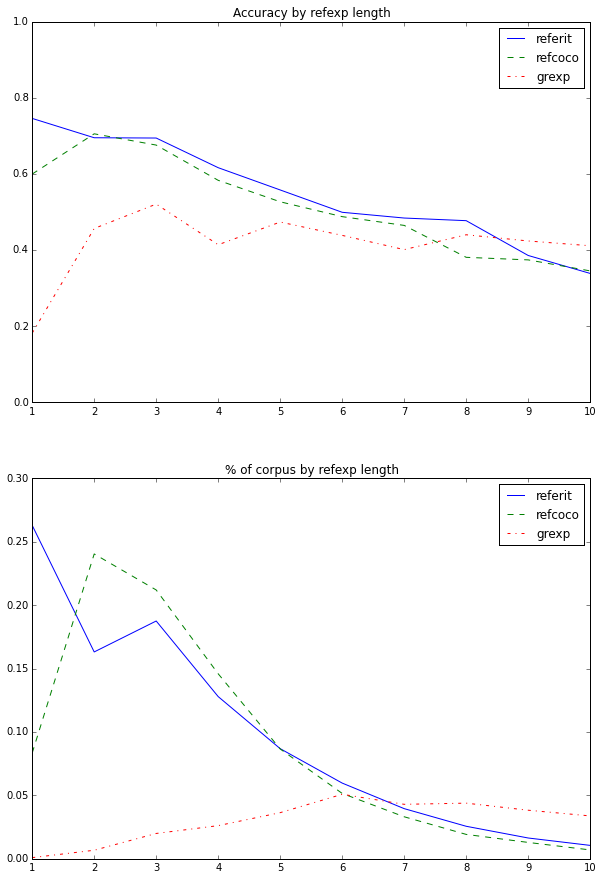

In [262]:
x = range(1,11)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.ylim((0,1))
plt.plot(x, y_r01)
plt.plot(x, y_r03, linestyle='--')
plt.plot(x, y_r04, linestyle='-.')
plt.legend(['referit', 'refcoco', 'grexp'])
plt.title('Accuracy by refexp length')
plt.subplot(2,1,2)
plt.ylim((0,0.3))
plt.plot(x, s_r01)
plt.plot(x, s_r03, linestyle='--')
plt.plot(x, s_r04, linestyle='-.')
plt.legend(['referit', 'refcoco', 'grexp'])
plt.title('% of corpus by refexp length')
plt.savefig('Figures/bylength.pdf', bb='tight')

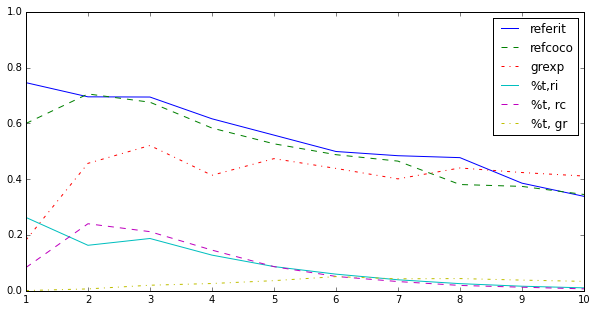

In [269]:
x = range(1,11)
plt.figure(figsize=(10,5))
#plt.subplot(2,1,1)
plt.ylim((0,1))
plt.plot(x, y_r01)
plt.plot(x, y_r03, linestyle='--')
plt.plot(x, y_r04, linestyle='-.')
#plt.legend(['referit', 'refcoco', 'grexp'])
#plt.title('Accuracy by refexp length')
#plt.subplot(2,1,2)
#plt.ylim((0,0.3))
plt.plot(x, s_r01)
plt.plot(x, s_r03, linestyle='--')
plt.plot(x, s_r04, linestyle='-.')
plt.legend(['referit', 'refcoco', 'grexp', '%t,ri', '%t, rc', '%t, gr'])
#plt.title('Accuracy and % of corpus by refexp length')
plt.savefig('Figures/bylength.pdf', bbox_inches='tight')

### What are we good / bad at?

In [282]:
def show_res(resdf, success=True, start=0, end=10):
    criterion = 'True' if success else 'False'
    query = 'suc == %s & cov > 0 & is_rel == False' % (criterion)
    return resdf.query(query).iloc[start:end][['image_id', 'region_id', 'refexp', 'rnk']]

In [284]:
show_res(r01, success=False, end=20)

image_id  region_id  \
2      14576          2   
9       2050          5   
14      2050         12   
15      2050          6   
29     19314          6   
30     19314          2   
34     19314          7   
35     19314          7   
45     26897          1   
47     26897          5   
48     26897          4   
50     26897          2   
51      9794          7   
52      9794          5   
55      9794          4   
57      9794          7   
60      9794          7   
62      9794          2   
69     12953         10   
70     12953         13   

                                                    refexp  rnk  
2                                       bottom left corner    2  
9                                  brown dirt to the right    4  
14                                     man in middle front    3  
15                                           grass on left    2  
29                                        the gross center    3  
30                                                 no left    6  
34                             open most sky in the center    2  
35                                     wow blue sky middle    2  
45                                                    door    2  
47                                          pot only right    2  
48                                potted plant to the left    2  
50                                            brick ground    3  
51                                            man on right    2  
52           the guy that might be about to take a picture    4  
55                                 second person from left    4  
57                                 person to the far right    2  
60                               guy furthest to the right    3  
62                                           ground bottom    2  
69                                  orange bottle in front    2  
70  plate on bottom of photo in the center with food on it    6

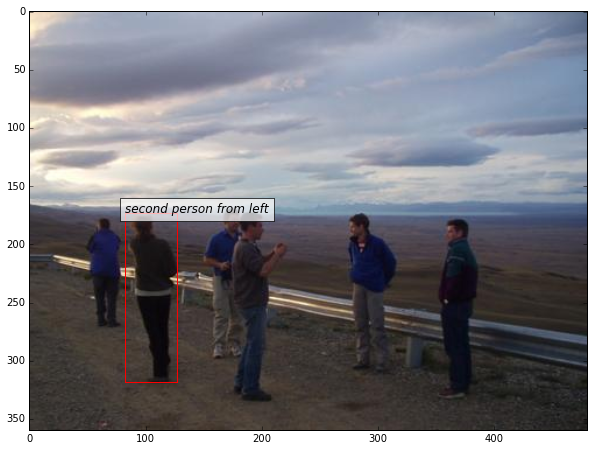

In [295]:
image_id = 9794
region_id = 4
refexp = 'second person from left'
bb = s_bbdf.query('image_id == %d & region_id == %d' % (image_id, region_id))['bb'].values[0]
plot_labelled_bb('../' + saiapr_image_filename(image_id), [[bb, refexp]])

In [298]:
show_res(r01, success=True, end=20)

image_id  region_id                      refexp  rnk
0      14576          1                        seal    1
3      20909          1                         kid    1
4      20909          3                 dirt ground    1
5      20909          2                     the sky    1
6       2050         10          man in red sweater    1
7       2050         10                  man in red    1
8       2050         10                     red guy    1
10      2050          8                 truck doors    1
11      2050         10                 dude in red    1
12      2050         11   guy in black jacket first    1
13      2050         10        red shirt right side    1
17      2050          3           my bad the people    1
18      2050         10                     red guy    1
19      2050          7  bushes left side of people    1
20      2050          4    white mountain far right    1
22      2050          1                         sky    1
23      2050         10                  man in red    1
24      2050         10            man on the right    1
25     25137          2       bottom right con\rner    1
26     25137          1                       plane    1

In [299]:
show_res(r03, success=False, end=20)

image_id  region_id                              refexp  rnk
1     580957    1537681            dish in top right corner    3
2     580957    1537681  white dish in the top right corner    3
3     580957    1537681        white pot upper right corner    2
7     580957     710706                             carrots    3
12    580905     469475             person holding umbrella    2
15    580785    1746473                               adult    2
17    580785    1741008         child sitting on womans lap    3
18    580785    1741008                   small girl on lap    3
19    580785    1741008                               child    3
25    580008    2159030                 guy wearing glasses    5
26    580008    2159030                  bottom picleft guy    2
27    580008     507653    woman in top picture on the left    2
33    579667      50194                          cat on top    2
34    579667      50194                      cat on the top    2
35    579667      50194                       cat at faucet    2
42    579440     466635             person in chair at left    2
43    579440     466635                 guy sitting on left    2
44    579440     466635        black shirt in chair on left    2
47    578808    2162742                      child in front    2
48    578808     513538                     woman in shorts    2

In [281]:
r03.query('suc == False & cov > 0 & is_rel == False')[['refexp', 'rnk']].head(20)

refexp  rnk
1             dish in top right corner    3
2   white dish in the top right corner    3
3         white pot upper right corner    2
7                              carrots    3
12             person holding umbrella    2
15                               adult    2
17         child sitting on womans lap    3
18                   small girl on lap    3
19                               child    3
25                 guy wearing glasses    5
26                  bottom picleft guy    2
27    woman in top picture on the left    2
33                          cat on top    2
34                      cat on the top    2
35                       cat at faucet    2
42             person in chair at left    2
43                 guy sitting on left    2
44        black shirt in chair on left    2
47                      child in front    2
48                     woman in shorts    2

### Analysing single classifiers

In [308]:
testfiles = ssplit90['test']
testdf = filter_by_filelist(srefdf, testfiles)
testdf['is_rel'] = testdf['refexp'].apply(is_relational)
testdf_norel = testdf.query('is_rel == False')
X_test = X[np.array([True if int(image_id) in testfiles else False for image_id in X[:,1]])]

In [311]:
vocab = wac_01.keys()
acvt = acc_vs_ntrain(testdf_norel, X_test, wac_01, vocab)

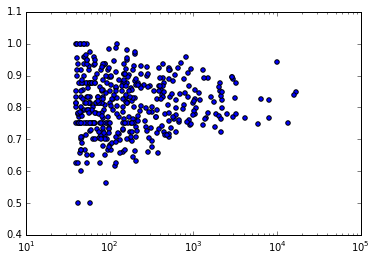

In [314]:
plt.scatter(*acvt)
plt.xscale('log')
plt.savefig('Figures/trainvsacc.png', bbox_inches='tight')